In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.append('../')
from utils.datasets import *
from utils.data_augmentation import *

In [5]:
def sum_dicts(dict1, dict2):
    return {k: dict1.get(k, 0) + dict2.get(k, 0) for k in set(dict1) | set(dict2)}

## Dataset pixel values distribution 

In [10]:
data_augmentation = "none"
img_size, crop_size = 224, 224 # We will take original image not transformed one
mask_reshape_method = "padd"
train_aug, train_aug_img, val_aug = data_augmentation_selector(
    data_augmentation, img_size, crop_size, mask_reshape_method
)

Using None Data Augmentation
Padding masks!
Padding masks!


In [11]:
add_depth = False
normalization = "none"
batch_size = 100

dataset = "mms"

only_end = False if "full" in dataset else True
unlabeled = True if "unlabeled" in dataset else False
c_centre = find_values(dataset, "centre", int)
c_vendor = find_values(dataset, "vendor", str)


train_dataset = MMs2DDataset(
    partition="Training", transform=train_aug, img_transform=train_aug_img, 
    normalization=normalization, add_depth=add_depth, 
    is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
    end_volumes=only_end, data_relative_path="../"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

print(f"Len train_dataset df: {len(train_dataset.data)}")

Len train_dataset df: 3284


In [8]:
total_counts = dict()
for batch_indx, batch in enumerate(tqdm(train_loader)):
    for original_img in batch["original_img"]:
        unique, counts = np.unique(original_img, return_counts=True)
        counts_dict = dict(zip(unique, counts))
        total_counts = sum_dicts(total_counts, counts_dict)

Text(0.5, 1.0, 'Distribution of MRI pixel values')

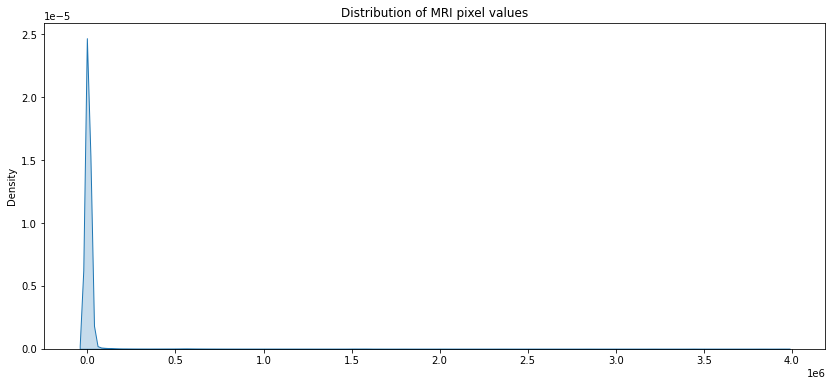

In [13]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# KDE plots for each species
sns.kdeplot(total_counts, shade=True)

# Add title
plt.title("Distribution of MRI pixel values")

## Masks Spatial Priors (distribution)

In [14]:
train_masks = []
for batch_indx, batch in enumerate(train_loader):
    train_masks.append(batch["label"])

In [15]:
train_masks = torch.cat(train_masks)
train_masks.shape

torch.Size([3284, 1, 224, 224])

In [31]:
print(f"Mask values: {train_masks.unique()}")

Mask values: tensor([0., 1., 2., 3.])


In [32]:
train_masks_lv = (train_masks == 1) * 1.0
train_masks_myo = (train_masks == 2) * 1.0
train_masks_rv = (train_masks == 3) * 1.0

In [33]:
# We can perform train_masks.sum() because class labels are 1 to count numer of pixels
mask_spatial_frecs_lv = (torch.sum(train_masks_lv, dim=0) / train_masks_lv.sum())
mask_spatial_frecs_myo = (torch.sum(train_masks_myo, dim=0) / train_masks_myo.sum())
mask_spatial_frecs_rv = (torch.sum(train_masks_rv, dim=0) / train_masks_rv.sum())
mask_spatial_frecs_lv.shape

torch.Size([1, 224, 224])

In [34]:
mask_sp_lv = mask_spatial_frecs_lv.squeeze(0)
mask_sp_lv_normalized = (mask_sp_lv / mask_sp_lv.max())

mask_sp_myo = mask_spatial_frecs_myo.squeeze(0)
mask_sp_myo_normalized = (mask_sp_myo / mask_sp_myo.max())

mask_sp_rv = mask_spatial_frecs_rv.squeeze(0)
mask_sp_rv_normalized = (mask_sp_rv / mask_sp_rv.max())

print(f"[Original LV mask prior] Max frec: {mask_sp_lv.max()}")
print(f"[Original LV mask prior] Min frec: {mask_sp_lv.min()}")
print(f"[Normalized LV mask prior] Max frec: {mask_sp_lv_normalized.max()}")
print(f"[Normalized LV mask prior] Min frec: {mask_sp_lv_normalized.min()}")

print(f"[Original MYO mask prior] Max frec: {mask_sp_myo.max()}")
print(f"[Original MYO mask prior] Min frec: {mask_sp_myo.min()}")
print(f"[Normalized MYO mask prior] Max frec: {mask_sp_myo_normalized.max()}")
print(f"[Normalized MYO mask prior] Min frec: {mask_sp_myo_normalized.min()}")

print(f"[Original RV mask prior] Max frec: {mask_sp_rv.max()}")
print(f"[Original RV mask prior] Min frec: {mask_sp_rv.min()}")
print(f"[Normalized RV mask prior] Max frec: {mask_sp_rv_normalized.max()}")
print(f"[Normalized RV mask prior] Min frec: {mask_sp_rv_normalized.min()}")

[Original LV mask prior] Max frec: 0.0007933381129987538
[Original LV mask prior] Min frec: 0.0
[Normalized LV mask prior] Max frec: 1.0
[Normalized LV mask prior] Min frec: 0.0
[Original MYO mask prior] Max frec: 0.00037680979585275054
[Original MYO mask prior] Min frec: 0.0
[Normalized MYO mask prior] Max frec: 1.0
[Normalized MYO mask prior] Min frec: 0.0
[Original RV mask prior] Max frec: 0.0004110329900868237
[Original RV mask prior] Min frec: 0.0
[Normalized RV mask prior] Max frec: 1.0
[Normalized RV mask prior] Min frec: 0.0


Text(0.5, 1.0, 'Train Masks LV Spatial Prior')

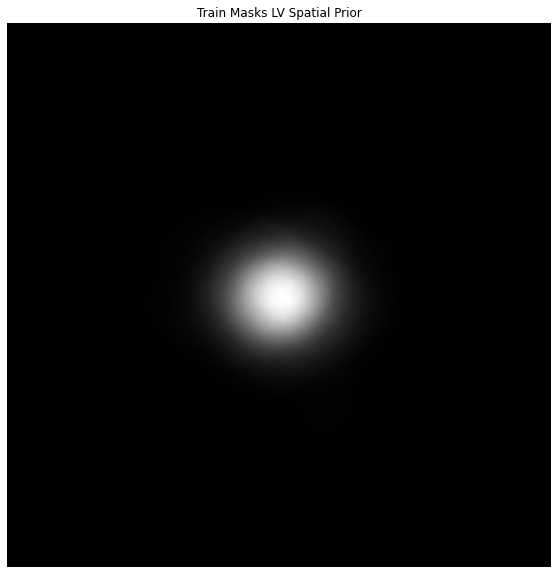

In [37]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_lv_normalized, cmap="gray")
plt.axis("off")
plt.title("Train Masks LV Spatial Prior")

Text(0.5, 1.0, 'Train Masks MYO Spatial Prior')

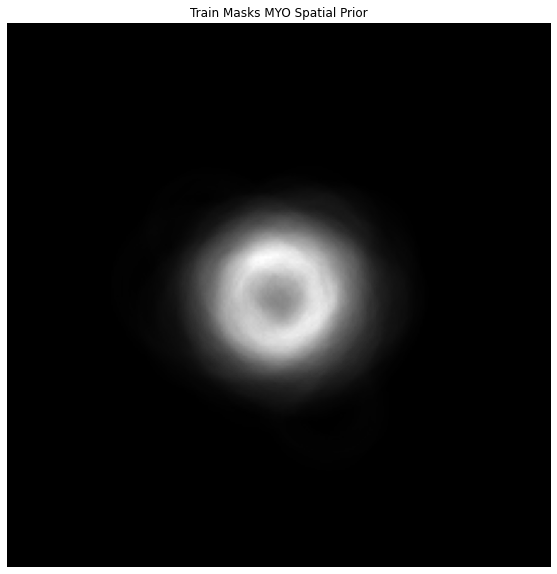

In [38]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_myo_normalized, cmap="gray")
plt.axis("off")
plt.title("Train Masks MYO Spatial Prior")

Text(0.5, 1.0, 'Train Masks RV Spatial Prior')

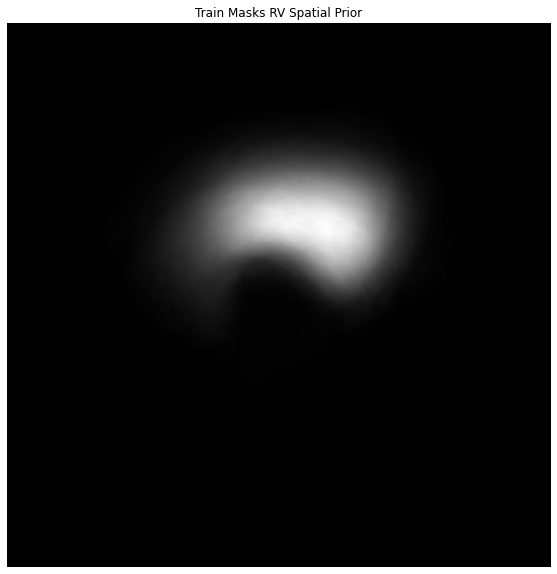

In [39]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_rv_normalized, cmap="gray")
plt.axis("off")
plt.title("Train Masks RV Spatial Prior")

In [40]:
sigma = 2
window_size = 70
truncate = (((window_size - 1)/2)-0.5)/sigma

mask_sp_lv_normalized_gaussian = gaussian_filter(
    mask_sp_lv_normalized, sigma=sigma, truncate=truncate
)

mask_sp_myo_normalized_gaussian = gaussian_filter(
    mask_sp_myo_normalized, sigma=sigma, truncate=truncate
)

mask_sp_rv_normalized_gaussian = gaussian_filter(
    mask_sp_rv_normalized, sigma=sigma, truncate=truncate
)

print(f"[Gaussian LV mask prior] Max frec: {mask_sp_lv_normalized_gaussian.max()}")
print(f"[Gaussian LV mask prior] Min frec: {mask_sp_lv_normalized_gaussian.min()}")

print(f"[Gaussian MYO mask prior] Max frec: {mask_sp_myo_normalized_gaussian.max()}")
print(f"[Gaussian MYO mask prior] Min frec: {mask_sp_myo_normalized_gaussian.min()}")

print(f"[Gaussian RV mask prior] Max frec: {mask_sp_rv_normalized_gaussian.max()}")
print(f"[Gaussian RV mask prior] Min frec: {mask_sp_rv_normalized_gaussian.min()}")

[Gaussian LV mask prior] Max frec: 0.9832746982574463
[Gaussian LV mask prior] Min frec: 0.0
[Gaussian MYO mask prior] Max frec: 0.952089786529541
[Gaussian MYO mask prior] Min frec: 0.0
[Gaussian RV mask prior] Max frec: 0.9736501574516296
[Gaussian RV mask prior] Min frec: 0.0


Text(0.5, 1.0, 'Train LV Masks Spatial Prior Gaussian Blur')

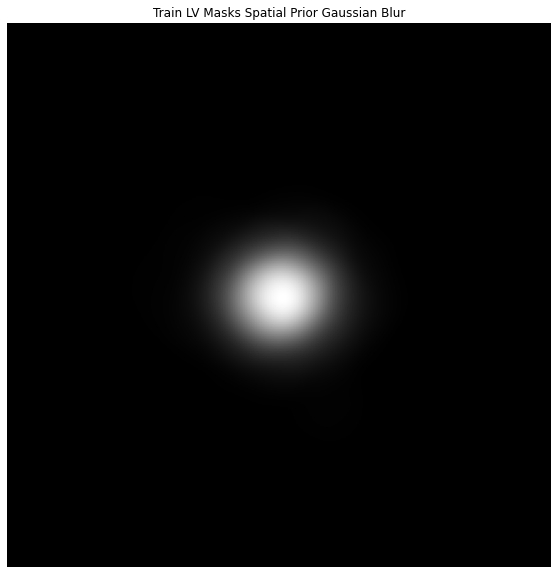

In [41]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_lv_normalized_gaussian, cmap="gray")
plt.axis("off")
plt.title("Train LV Masks Spatial Prior Gaussian Blur")

Text(0.5, 1.0, 'Train MYO Masks Spatial Prior Gaussian Blur')

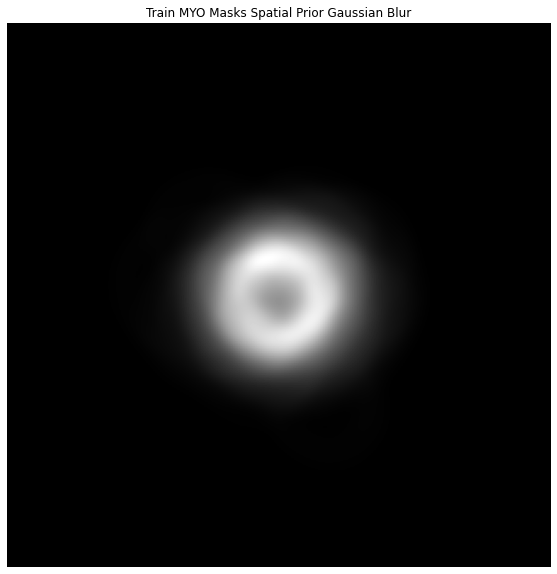

In [42]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_myo_normalized_gaussian, cmap="gray")
plt.axis("off")
plt.title("Train MYO Masks Spatial Prior Gaussian Blur")

Text(0.5, 1.0, 'Train RV Masks Spatial Prior Gaussian Blur')

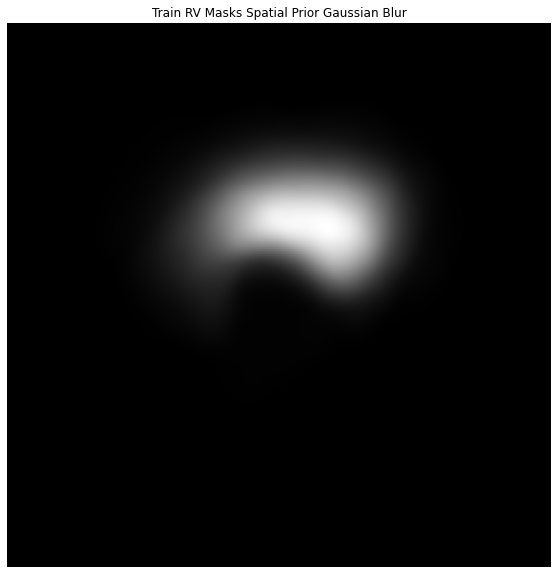

In [43]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_rv_normalized_gaussian, cmap="gray")
plt.axis("off")
plt.title("Train RV Masks Spatial Prior Gaussian Blur")

(-0.5, 223.5, 223.5, -0.5)

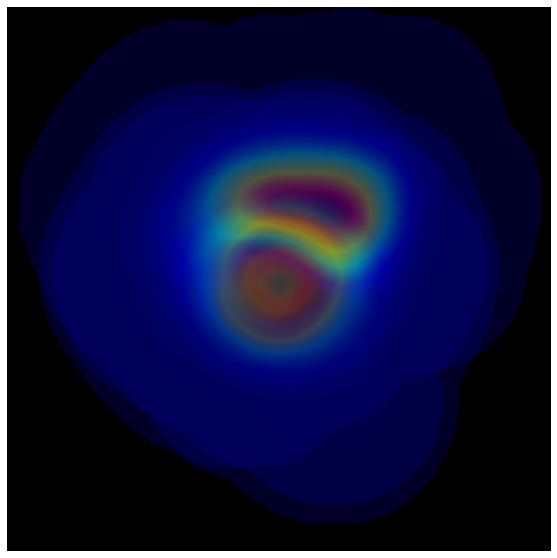

In [69]:
plt.figure(figsize=(10,10))
masked_lv = np.ma.masked_where(mask_sp_lv_normalized_gaussian == 0, mask_sp_lv_normalized_gaussian)
masked_myo = np.ma.masked_where(mask_sp_myo_normalized_gaussian == 0, mask_sp_myo_normalized_gaussian)
masked_rv = np.ma.masked_where(mask_sp_rv_normalized_gaussian == 0, mask_sp_rv_normalized_gaussian)

plt.imshow(np.zeros((224, 224)), cmap="gray")
plt.imshow(masked_lv, 'jet', interpolation='bilinear', alpha=0.33)
plt.imshow(masked_myo, 'jet', interpolation='bilinear', alpha=0.33)
plt.imshow(masked_rv, 'jet', interpolation='bilinear', alpha=0.33)
plt.axis("off")

Should we add a smooth value to non 0s?

## Dataset pixel values distribution Deeper

In [3]:
data_augmentation = "none"
img_size, crop_size = 224, 224 # We will take original image not transformed one
mask_reshape_method = "padd"
train_aug, train_aug_img, val_aug = data_augmentation_selector(
    data_augmentation, img_size, crop_size, mask_reshape_method
)

Using None Data Augmentation
Padding masks!
Padding masks!


In [16]:
add_depth = False
normalization = "none"
batch_size = 100

dataset = "mms_unlabeled_vendorC"

only_end = False if "full" in dataset else True
unlabeled = True if "unlabeled" in dataset else False
c_centre = find_values(dataset, "centre", int)
c_vendor = find_values(dataset, "vendor", str)


train_dataset = MMs2DDataset(
    partition="Training", transform=train_aug, img_transform=train_aug_img, 
    normalization=normalization, add_depth=add_depth, 
    is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
    end_volumes=only_end, data_relative_path="../"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

print(f"Len train_dataset df: {len(train_dataset.data)}")

Len train_dataset df: 287


In [17]:
total_counts = dict()
for batch_indx, batch in enumerate(tqdm(train_loader)):
    for original_img in batch["original_img"]:
        unique, counts = np.unique(original_img, return_counts=True)
        counts_dict = dict(zip(unique, counts))
        total_counts = sum_dicts(total_counts, counts_dict)

Text(0.5, 1.0, 'Distribution of MRI pixel values')

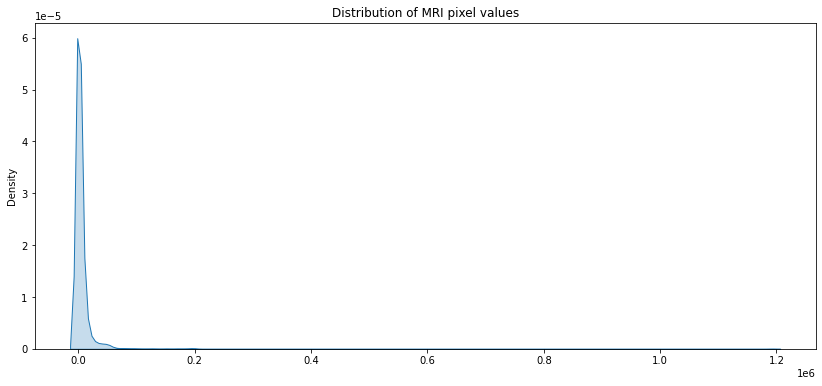

In [18]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# KDE plots for each species
sns.kdeplot(total_counts, shade=True)

# Add title
plt.title("Distribution of MRI pixel values")

In [27]:
add_depth = False
normalization = "none"
batch_size = 100

dataset = "mms_unlabeled_vendorA_full"

only_end = False if "full" in dataset else True
unlabeled = True if "unlabeled" in dataset else False
c_centre = find_values(dataset, "centre", int)
c_vendor = find_values(dataset, "vendor", str)


train_dataset = MMs2DDataset(
    partition="Training", transform=train_aug, img_transform=train_aug_img, 
    normalization=normalization, add_depth=add_depth, 
    is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
    end_volumes=only_end, data_relative_path="../"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

print(f"Len train_dataset df: {len(train_dataset.data)}")

Len train_dataset df: 19987


In [28]:
train_dataset.data

,External code,VendorName,Vendor,Centre,Partition,Labeled,ED,ES,Slice,Phase
0,A0S9V9,Siemens,A,1,Training,False,0,9,0,1
1,A0S9V9,Siemens,A,1,Training,False,0,9,0,2
2,A0S9V9,Siemens,A,1,Training,False,0,9,0,3
3,A0S9V9,Siemens,A,1,Training,False,0,9,0,4
4,A0S9V9,Siemens,A,1,Training,False,0,9,0,5
...,...,...,...,...,...,...,...,...,...,...
19982,T9U9W2,Siemens,A,1,Training,False,0,10,10,20
19983,T9U9W2,Siemens,A,1,Training,False,0,10,10,21
19984,T9U9W2,Siemens,A,1,Training,False,0,10,10,22
19985,T9U9W2,Siemens,A,1,Training,False,0,10,10,23


In [21]:
total_counts = dict()
for batch_indx, batch in enumerate(tqdm(train_loader)):
    for original_img in batch["original_img"]:
        unique, counts = np.unique(original_img, return_counts=True)
        counts_dict = dict(zip(unique, counts))
        total_counts = sum_dicts(total_counts, counts_dict)

Text(0.5, 1.0, 'Distribution of MRI pixel values')

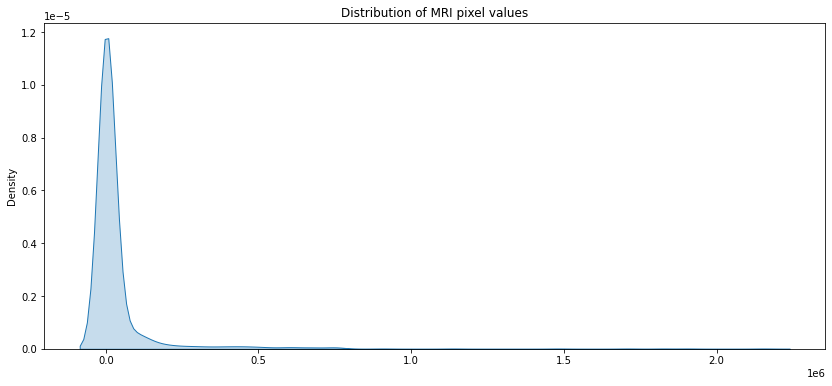

In [22]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# KDE plots for each species
sns.kdeplot(total_counts, shade=True)

# Add title
plt.title("Distribution of MRI pixel values")